# Working with data 2017. Class 6
## Contact
Javier Garcia-Bernardo
garcia@uva.nl

## 1. Data sources

## 2. OCR (Read PDFs)

## 3. Regular expressions

## 4. Pandas IV: Operations with text: 0.5 hours

## 5. Classifying text
- Counting words
- Machine learning
- LDA

## 6. Sentiment analysis

If you are interested in these topics, please take Damian Trillin's class, it also uses Python :)  http://studiegids.uva.nl/xmlpages/page/2016-2017/zoek-vak/vak/28477

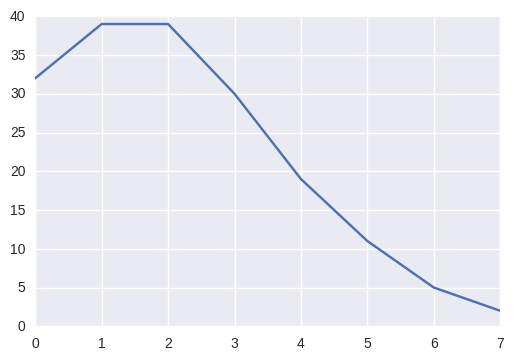

In [105]:
a = [1,2,3,4,3,2]
b = [1,1,2,3,4,3]
#plt.plot(a)
#plt.plot(b)
plt.plot(np.correlate(a,b,mode="full")[3:])

In [ ]:
#!/usr/bin/python

#-----------------------------------------------------------------------
# twitter-search-geo
#  - performs a search for tweets close to New Cross, and outputs
#    them to a CSV file.
#-----------------------------------------------------------------------
import sys
import csv

latitude = 52.3740300	# geographical centre of search
longitude = 4.8896900	# geographical centre of search
max_range = 10 			# search range in kilometres
num_results = 1000		# minimum results to obtain
outfile = "output.csv"

import tweepy
# enter twitter info from [Twitter developers site][2]         
CONSUMER_KEY = 'mw9ElLqk5F3kEaTta882lAIuP'
CONSUMER_SECRET = 'AMF4ZRjmese7rRYj2NbBaA4mEGUF95Y4r0tZ89mCmj4m7IcC5X'
ACCESS_KEY = '824274390800011266-saD1Us4iSO5bJeJqjOwt1ibOIABvTUd'
ACCESS_SECRET = 'OGEH51sX8Ak0IKENXxRDbBmgqeOuzedBcgUeZaZ0E0Mqh'

# setup authorization
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)


print(last_id)
api = tweepy.API(auth)

#-----------------------------------------------------------------------
# open a file to write (mode "w"), and create a CSV writer object
#-----------------------------------------------------------------------
with open(outfile, "w+") as csvfile:
    csvwriter = csv.writer(csvfile)

    #-----------------------------------------------------------------------
    # add headings to our CSV file
    #-----------------------------------------------------------------------

    #-----------------------------------------------------------------------
    # the twitter API only allows us to query up to 100 tweets at a time.
    # to search for more, we will break our search up into 10 "pages", each
    # of which will include 100 matching tweets.
    #-----------------------------------------------------------------------
    result_count = 0
    last_id = None
    while result_count <  num_results:
        #-----------------------------------------------------------------------
        # perform a search based on latitude and longitude
        # twitter API docs: https://dev.twitter.com/docs/api/1/get/search
        #-----------------------------------------------------------------------
        import time


        query = api.search(q = "trein", lang = "nl",  
                              geocode = "{},{},{}km".format(latitude, longitude, max_range), 
                              count = 90, max_id = last_id,result_type="recent")
        #print(len(query), end =" ")
        
        for result in query:
            #-----------------------------------------------------------------------
            # only process a result if it has a geolocation
            #-----------------------------------------------------------------------

            user = result.user.screen_name
            text = result.text
            followers_count = result.user.followers_count
            time_zone = result.user.time_zone
            print(str(result.created_at),result.id)
            if result.geo is not None:                 
                lat,lon = result.geo["coordinates"]
            else:
                lat,lon = "",""
                #print(result.geo)
          

            # now write this row to our CSV file
            row = [ user, text, latitude, longitude,followers_count, time_zone]
            csvwriter.writerow(row)
            result_count += 1
            
        last_id = int(result.id)-1
        
        #-----------------------------------------------------------------------
        # let the user know where we're up to
        #-----------------------------------------------------------------------
        print ("got %d results" % result_count)
        time.sleep(2)


print ("written to %s" % outfile)

In [43]:
#Some libraries we need
!pip install nltk
!pip install labMTsimple
!pip install seaborn
!pip install matplotlib
!pip install pandas --upgrade
!pip install scipy
!pip install numpy
!pip install selenium --upgrade
!pip install labMTsimple
!pip install lda

    100% |████████████████████████████████| 3.7MB 435kB/s 
  Running setup.py bdist_wheel for labMTsimple ... - \ done
  Stored in directory: /home/jgarcia1/.cache/pip/wheels/83/e8/b7/f230870f8f5ce71496c04bc238c5184ce996d28e2e0d24b90c
Successfully built labMTsimple
Requirement already up-to-date: pandas in /opt/anaconda/anaconda3/lib/python3.5/site-packages
    100% |████████████████████████████████| 194kB 5.2MB/s 
    100% |████████████████████████████████| 491kB 3.3MB/s 
    100% |████████████████████████████████| 16.8MB 102kB/s 
Requirement already up-to-date: six>=1.5 in /opt/anaconda/anaconda3/lib/python3.5/site-packages (from python-dateutil>=2->pandas)
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninstalled python-dateutil-2.5.3
  Found existing installation: pytz 2016.6.1
    DEPRECATION: Uninstalling a distutils installed project (pytz) has been deprecated and will be removed in a future version. This is d

In [44]:
import pandas as pd
import numpy as np
import pylab as plt
import seaborn as sns
import nltk

#Visualize in line
%matplotlib inline

#Be able to plot images saved in the hard drive
from IPython.display import Image,display

#Make the notebook wider
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:90% !important; }</style>"))



**DOWNLOAD PACKAGES stopwords, punkt and wordnet from nltk (needed for stemming and tokenizing)**



In [62]:
import nltk
nltk.download()


NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords
      Package stopwords is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt
      Package punkt is already up-to-date!

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Ide

True

## 1. Data sources
- LAPOP data (http://www.vanderbilt.edu/lapop/survey-data.php)
- CSES data (http://www.cses.org/datacenter/module4/module4.htm)
- COMTRADE data (https://comtrade.un.org/data/)
- Economic data (http://orbis.bvdinfo.com/ip/)
- Others (EU Social survey, Afrobarometer, http://www.paulhensel.org/compendium.html)
- Twitter / Facebook (using APIs)
- LexisNexis (newspaper data): academic.lexisnexis.eu
- Many others

## 2. OCR (Read PDFs)
- Good: http://www.un.org/ga/search/view_doc.asp?symbol=S/2016/1137
- Bad: http://www.un.org/en/ga/search/view_doc.asp?symbol=S/1994/529
    - First: Do OCR (optical character recognition): http://www.cvisiontech.com/online-conversion/general/main.html
 
 
 
We can easily get the text of the pdf:
- Get text from the pdf: http://pdftotext.com/

## 3. Regular expressions
- They are combination of characters that match some text
- "Count\d" matches Count0,Count1,Count2,Count3... ("\d" means number)


How to construct them:
- \d = number
- \s = any spacing (tab/space)
- [a-zA-Z] = any letter
- . = any character
- ^ = match at the beginning of the string
- $ = match at the end of the string
- ? = match 0 or 1 times the previous symbol
- \* = match any number of times the previous symbol (0,1,2...)
- \+ = match 1 or more times the previous symbol


Library:
- import re
- match = re.search(pattern, string)

In [7]:
import re

In [8]:
match = re.search("Count\d","some text Count1122")
match_st = match.start()
match_end = match.end()
print(match_st,match_end,match.group())

10 16 Count1


In [52]:
dates = ["September 27, 2016 Tuesday  FIRST EDITION",
        "October 12, 2015",
        "March 1, 2013 International Edition"]


for string in dates:
    last_index = re.search("\d\d\d\d",string).end()
    print(string[:last_index])

September 27, 2016
October 12, 2015
March 1, 2013


## 4. LexisNexis
http://academic.lexisnexis.eu/

In [107]:
import random
import re
import os
import requests
import urllib.request, urllib.parse, urllib.error
import urllib.parse as urlparse
import bs4 as bs
import time

import selenium.common.exceptions
import selenium.webdriver
import selenium.webdriver.common.desired_capabilities
import selenium.webdriver.support.ui
from selenium.webdriver.support import expected_conditions


class LexisNexisScraper():
    """
    Class for downloading documents given a query string to Lexis Nexis academic (http://www.lexisnexis.com/hottopics/lnacademic/).

    Example::

            downloader = LexisNexisScraper(mass_download_mode=True)
            for (content, (doc_index, doc_count)) in downloader.iter_search_results(6318, 'DATE(=1987)'):
                print doc_id

     """

    _RE_STYLESHEET = re.compile(r'\<STYLE TYPE\=\"text\/css\"\>(\<\!\-\-)?(?P<css_string>.+?)(\-\-\>)?\<\/STYLE\>', flags=re.S | re.U | re.I)
    _RE_LEXIS_DOC = re.compile(r'\<DOC NUMBER\=(?P<docid>\d+)\>\s+\<DOCFULL\>(?P<doc>.+?)\<\/DOCFULL\>', flags=re.S | re.U | re.I)
    #15 180
    def __init__(self, wait_timeouts=(30, 180), documents_per_download=(250, 500), 
                 user_agent_string='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; rv:25.0) Gecko/20100101 Firefox/25.0', 
                 mass_download_mode=False,executable_path="./geckodriver"):
        """
        Constructs a downloader object.

        :param float,float wait_timeouts: tuple of `(short, long)` where `short` and `long` are the no. of seconds to wait while page elements are loaded (for Webdriver). `long` timeout is used when waiting for LexisNexis to format documents for mass downloads.
        :param int,int documents_per_download: a range specifying the number of documents to download each time when using :attr:`mass_download_mode`.
        :param bool mass_download_mode: whether to mass download articles using the download link or page through each document one by one and download.
        """

        self._USER_AGENT_STRING = user_agent_string
        self._DOCUMENTS_PER_DOWNLOAD = documents_per_download
        
        self._driver = selenium.webdriver.Firefox(executable_path=executable_path)#Chrome(chromedriver)
        #self._driver.set_window_size(800, 600)
        self._driver.maximize_window()

        self._short_wait = selenium.webdriver.support.ui.WebDriverWait(self._driver, wait_timeouts[0], poll_frequency=0.05)
        self._long_wait = selenium.webdriver.support.ui.WebDriverWait(self._driver, wait_timeouts[1], poll_frequency=1)

        self.mass_download_mode_ = mass_download_mode
    #end def

    def __del__(self):
        try: self._driver.quit()
        except: pass

    def iter_search_results(self, csi, search_query, start_from=1):
        """
        A generator function that executes LexisNexis search query on source data CSI (:attr:`csi`), with query :attr:`search_query` and downloads all documents returned by search.

        :param str csi: LexisNexis CSI (see `<http://amdev.net/rpt_download.php>`_ for full list).
        :param str search_query: execute search query string.
        :param int start_from: document index to start downloading from.
        :returns: a tuple `(doc_content, (index, results_count))`, where `doc_content` is the HTML content of the `index`th document, and `results_count` is the number of documents returned by specified search query.
        """

        self._driver.get('http://www.lexisnexis.com/hottopics/lnacademic/?' + urllib.parse.urlencode({'verb': 'sr', 'csi': csi, 'sr': search_query}))
        if not self._have_results(): return []

        if self.mass_download_mode_: return self._mass_download(start_from)
        return self._sequential_download(start_from)
    #end def

    def _have_results(self):    # todo: kinda slow, due to having wait for multiple timeouts
        self._switch_to_frame('main')
        if self._wait_for_element('//td[text()[contains(., "No Documents Found")]]', raise_error=False) is not None: return False
        if self._wait_for_element('//frame[@title="Results Content Frame"]', raise_error=False) is not None: return True
        if self._wait_for_element('//frame[@title="Results Document Content Frame"]', raise_error=False) is not None: return True

        raise Exception('Page loaded improperly while checking for results frame.')
    #end def

    def _mass_download(self, start_from=1):    # Returns documents as a list of strings containing HTML
        try: documents_count = int(self._driver.execute_script("return documentCount;"))
        except: documents_count = -1
        self._switch_to_frame('navigation')
      

        def download_sequence(start, end):
            docs_left = end - start + 1
            cur = start
            while docs_left > self._DOCUMENTS_PER_DOWNLOAD[1]:
                download_count = random.randint(*self._DOCUMENTS_PER_DOWNLOAD)
                yield (cur, cur + download_count - 1)
                docs_left -= download_count
                cur += download_count
            #end while

            yield (cur, cur + docs_left - 1)
        #end def

        def lexis_nexis_download_window_appears(current_handle):
            def f(driver):
                for handle in driver.window_handles:
                    if current_handle != handle:
                        driver.switch_to.window(handle)    # switch first to check window title
                        if driver.title.endswith('Download Documents'): return True    # this is our new window!
                    #end if
                #end for

                return False
            #end def

            return f
        #end class

        for download_start, download_end in download_sequence(start_from, documents_count):
            self._switch_to_frame('navigation')

            parent_window_handle = self._driver.current_window_handle

            # check for download icon and click it
            self._wait_for_element('//img[@title="Download Documents"]').click()

            # wait for download window to appear
            self._short_wait.until(lexis_nexis_download_window_appears(parent_window_handle))
            self._wait_for_element('//img[@title="Download"]')

            # get all the form items
            self._driver.find_element_by_xpath('//*[@id="delFmt"]/option[2]').click()
            self._driver.find_element_by_xpath('//*[@id="delView"]/option[4]').click()
            self._driver.find_element_by_xpath('//*[@id="delFontType"]/option[3]').click()

            #selenium.webdriver.support.ui.Select(self._driver.find_element_by_xpath('//select[@name="delFmt"]')).select_by_value('QDS_EF_HTML')
            #selenium.webdriver.support.ui.Select(self._driver.find_element_by_xpath('//select[@name="delView"]')).select_by_value('GNBFI')
            #selenium.webdriver.support.ui.Select(self._driver.find_element_by_xpath('//select[@name="delFontType"]')).select_by_value('COURIER')    # i like courier

            search_term_bold = self._driver.find_element_by_xpath('//input[@type="checkbox"][@id="termBold"]')
            if not search_term_bold.is_selected(): search_term_bold.click()
            doc_new_page = self._driver.find_element_by_xpath('//input[@type="checkbox"][@id="docnewpg"]')
            if not doc_new_page.is_selected(): doc_new_page.click()

            self._driver.find_element_by_xpath('//input[@type="radio"][@id="sel"]').click()
            self._driver.find_element_by_xpath('//input[@type="text"][@id="rangetextbox"]').send_keys('{}-{}'.format(download_start, download_end))
            time.sleep(0.1)
            self._driver.find_element_by_xpath('//img[@title="Download"]').click()
            
            
            
            self._long_wait.until(expected_conditions.presence_of_element_located((selenium.webdriver.common.by.By.XPATH, '//*[@id="center"]/center/p/a')))
            download_url = self._driver.find_element_by_xpath('//*[@id="center"]/center/p/a').get_attribute("href")
       
            # set up cookies and use requests library to do download
            cookies = dict([(cookie['name'], cookie['value']) for cookie in self._driver.get_cookies()])
            response = requests.get(download_url, cookies=cookies, headers={'User-Agent': self._USER_AGENT_STRING})
            html_content = response.text

            m = self._RE_STYLESHEET.search(html_content)
            try: css_string = m.group('css_string').strip()
            except: css_string = ""
                
        
            for i, m in enumerate(self._RE_LEXIS_DOC.finditer(html_content)):
                page_content = m.group('doc').replace('<!-- Hide XML section from browser', '').replace('-->', '').strip()
                page_content = '\n'.join(['<HTML>', '<HEAD>', '<STYLE TYPE=\"text/css\">', css_string, '</STYLE>', '</HEAD>', '<BODY>', page_content, '</BODY>', '</HTML>'])

                yield (page_content, (download_start + i, documents_count))
            #end for

            self._driver.close()
            self._driver.switch_to.window(parent_window_handle)
        #end for
    #end def

    def _sequential_download(self, start_from=1):
        self._switch_to_frame('navigation')
        try: documents_count = int(self._driver.find_element_by_xpath('//form[@name="results_docview_DocumentForm"]/input[@name="totalDocsInResult"]').get_attribute('value'))
        except: documents_count = -1
        if documents_count <= 0: return

        if start_from > documents_count: return

        if documents_count == 1:
            self._switch_to_frame('content')
            page_content = self._driver.page_source
            yield (page_content, (1, 1))
            return
        #end if

        self._switch_to_frame('results')    # go to results list and grab the first link
        first_document_url = self._wait_for_element('//td/a[contains(@href, "/lnacui2api/results/docview/docview.do")]').get_attribute('href')

        url_obj = urlparse.urlparse(first_document_url)
        qs_dict = dict(urlparse.parse_qsl(url_obj.query))
        qs_dict['docNo'] = start_from
        doc_url = urlparse.urlunparse((url_obj.scheme, url_obj.netloc, url_obj.path, url_obj.params, urllib.parse.urlencode(qs_dict), url_obj.fragment))
        self._driver.get(doc_url)    # jump to the page we want

        # qs_dict['RELEVANCE'] = 'BOOLEAN'    # doesnt seem to work
        # http://www.lexisnexis.com/lnacui2api/results/docview/docview.do?docLinkInd=true&risb=21_T21153102977&format=GNBFI&sort=RELEVANCE&startDocNo=1&resultsUrlKey=29_T21153102981&cisb=22_T21153102980&treeMax=true&treeWidth=0&csi=6318&docNo=1

        for doc_index in range(start_from, documents_count + 1):
            self._switch_to_frame('content', in_iframe=False)
            page_content = self._driver.page_source
            yield (page_content, (doc_index, documents_count))

            self._switch_to_frame('navigation', in_iframe=False)
            next_page_elem = self._wait_for_element('//img[@title="View next document"]', raise_error=False)
            if next_page_elem is None:
                if doc_index != documents_count:
                    raise Exception('Next page icon could not be found: doc_index={}, documents_count={}'.format(doc_index, documents_count))
            else: next_page_elem.click()
        #end while
    #end def

    def _switch_to_frame(self, frame_name, in_iframe=True):
        self._driver.switch_to.default_content()

        if in_iframe:
            #self.driver
            
            
            frame = self._safe_wait(expected_conditions.frame_to_be_available_and_switch_to_it('mainFrame'))
            if not frame: 
                try: 
                    self._driver.switch_to.frame(self._driver.find_element_by_name('mainFrame'))
                except: 
                    raise SwitchFrameException(frame_name)
        #end if

        try:
            if frame_name == 'main': return frame
            elif frame_name == 'results': frame = self._wait_for_element('//frame[@title="Results Content Frame"]')
            elif frame_name == 'navigation': frame = self._wait_for_element('//frame[@title="Results Navigation Frame"]')
            elif frame_name == 'content': frame = self._wait_for_element('//frame[@title="Results Document Content Frame"]')
        except selenium.common.exceptions.TimeoutException:
            raise SwitchFrameException(frame_name)

        self._safe_wait(expected_conditions.frame_to_be_available_and_switch_to_it(frame))

        return frame
    #end def

    def _safe_wait(self, poll_func):
        try: return self._short_wait.until(poll_func)
        except selenium.common.exceptions.TimeoutException: return None
    #end def

    def _wait_for_element(self, xpath, raise_error=True):
        elem = self._safe_wait(expected_conditions.presence_of_element_located((selenium.webdriver.common.by.By.XPATH, xpath)))
        if raise_error and elem is None: raise selenium.common.exceptions.TimeoutException(msg='XPath "{}" presence wait timeout.'.format(xpath))
        return elem
    #end def
#end class


class SwitchFrameException(Exception):
    """
    Exception class when we are unable to load the require page properly.
    This is usually due to
    #. Page taking too long to load. This happens sometimes when loading LexisNexis for the first time.
    #. Improper page loading.
    """

    def __init__(self, frame_name): self.frame_name = frame_name

    def __str__(self): return 'Exception while switching to frame "{}".'.format(self.frame_name)
#end class


def scrape_news(csi,init_date,end_date,search,path="./",executable_path="./geckodriver"):
    """
    call the code from that other person, saves the results (one file = one article)
    """
    import os      
    os.makedirs(os.path.dirname(path), exist_ok=True)
    query = "({0}) AND Date(geq({1}) AND leq({2}))".format(search,init_date,end_date)

    scraper = LexisNexisScraper(mass_download_mode=True,executable_path=executable_path)

    for (content, (doc_index, doc_count)) in scraper.iter_search_results(csi,query):
        with open("{0}/{1}_{2}_{3}.html".format(path,end_date.replace("/","_"),doc_index, doc_count), "w+") as fOut:
            fOut.write(content)    


def format_new(content):
    """
    finds the article as a paragraph with class c8 or c9, and the other parts that we want too
    """
    
    html = bs.BeautifulSoup(content)
    #print(html.prettify())
    new = " ".join([_.text for _ in html.find_all("p",{"class": ["c8","c9","c10"]}) if len(_.text) > 100])
    other_parts = html.find_all("p",{"class": "c1"})
    date = other_parts[2].text

    date = date[:re.search("\d\d\d\d",date).end()]
    newspaper = other_parts[1].text
    
    return date,newspaper,new

def format_all_files(path_raw,file_out_name,search,path_save="data/"):
    """
    format the files, saving date, newspaper and article and saves the result
    """
    import os      
    os.makedirs(os.path.dirname(path_save), exist_ok=True)
    
    with open("{}{}".format(path_save,file_out_name),"w+") as fOut:        
        for file in sorted(os.listdir(path_raw)):
            try: date,newspaper,article = format_new(open("{}{}".format(path_raw,file)))    
            except:
                print(file)
                continue
            if len(article) > 100:
                fOut.write("{0}\t{1}\t{2}\n".format(date,newspaper,article))
      



# Let's see how newspapers talked about Trump and China
- USA TODAY (neutral): 8213
- New york times (liberal): 6742
- New york post (conservative): 164207


In [22]:
Image(url="http://assets.pewresearch.org/wp-content/uploads/sites/13/2014/10/PJ_14.10.21_mediaPolarization-08.png")

In [7]:
pwd

'/home/javiergb/serverOffice/classroom/classes/wwd2017/class6'

In [14]:


#!export PATH=$PATH:/home/javiergb/serverOffice/classroom/classes/wwd2017/class6/geckodriver


<selenium.webdriver.firefox.webdriver.WebDriver (session="09431b3b-8fb8-4c35-bf1a-9c2550bc5acf")>

### This downloads all newspaper articles from the new york times (liberal), the new york post (conservative) and USA Today (neutral), with the keywords Trump AND china

In [ ]:
for csi in ["8213","6742","164207"]:
    ##USAGE
    #CSI = Newspaper identifier:  http://amdev.net/rpt_download.php?reg=EUR
    print(csi)
    
    #Initial and final dates
    init_date = "1/25/2016" #format: mm/dd/yyyy
    end_date = "1/25/2017"  #format: mm/dd/yyyy

    #Query (Use AND, OR, and parenthesis), saves the results to /data/news_raw
    path = "./data/news_raw_{}/".format(csi)
    search = "Trump AND China"
    scrape_news(csi,init_date,end_date,search,path=path,executable_path="./geckodriver")

    #Where to save the results, formatting it as date, newspaper, article
    file_out_name = "{}_{}.csv".format(search.replace(" ","_"),csi)
    format_all_files(path,file_out_name,search,path_save)



In [111]:
for year in [1]:#range(1993,2017):
    print(year)
    
    for csi in ["168873","315336","294298","304134","259064","259069"]:
        ##USAGE
        #CSI = Newspaper identifier:  http://amdev.net/rpt_download.php?reg=EUR
        print(csi)

        #Initial and final dates
        init_date = "1/1/{}".format(year) #format: mm/dd/yyyy
        end_date = "1/1/{}".format(year+1)  #format: mm/dd/yyyy

        #Query (Use AND, OR, and parenthesis), saves the results to /data/news_raw
        path = "./data_klimaat/news_raw_{}/".format(csi)
        #search = "(klimaat AND (verander* OR opwarm* OR trend* OR aanpass*)) OR (broeikas* AND (effect* or gas*)) OR ((glob* OR aarde* OR wereld* OR internationa* OR atmosfeer) AND (warm* OR verwarm* OR opwarm* OR verkoel* OR afkoel*)) OR ((temperatuur* AND (glob* OR aarde* OR wereld* OR internationa* OR atmosfeer) AND (stijg* OR toename* OR toenem* OR dalen* OR daling OR afnem* OR afname*))"
        #scrape_news(csi,init_date,end_date,search,path=path,executable_path="./geckodriver")

        #Where to save the results, formatting it as date, newspaper, article
        file_out_name = "{}_{}.csv".format(year,csi)
        format_all_files(path,file_out_name,search,path_save="./data_klimaat/")



1
168873



The code that caused this warning is on line 184 of the file /opt/anaconda/anaconda3/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")
 [__init__.py:181]


1_1_2017_337_381.html
315336
294298
304134
259064
259069


## 4. Pandas IV: Operations with text


In [ ]:
##Summary (Don't run)
df["new_variable"] = df["Message"].str.contains("Trump") #Check in the column "Message" is Trump is contained. Contains can be a regular expression. In this case we need an r before our pattern: r"Trump|China" -> Trump or china
df["new_variable"] = df["Message"].str.count("Trump") #Count the number of times the word "Trump" occurs in each message
df["Message_lowercase"] = df["Message"].str.lower() #Make the message lowercase
df["new_variable"] = df["Message"].str.len() #Calculates the length of the message
df["Message_replaced"] = df["Message"].str.replace("word1","word2") #Replaces each occurence of "word1" by "word2" in each message
df["Message_replaced"] = df["Message"].str.split(",") #Split the message in each comma (creating a list)

#More: http://pandas.pydata.org/pandas-docs/stable/text.html

**Read the data we just downloaded**

In [46]:
df_usa_today = pd.read_csv("data/Trump_AND_China_6742.csv",sep="\t",header=None,parse_dates=[0]).sample(150)
df_usa_today[1] = "USA Today" #we change the newspaper name 

df_ny_times = pd.read_csv("data/Trump_AND_China_8213.csv",sep="\t",header=None,parse_dates=[0]).sample(150)
df_ny_times[1] = "New York Times"

df_ny_post = pd.read_csv("data/Trump_AND_China_164207.csv",sep="\t",header=None,parse_dates=[0]).sample(150)
df_ny_post[1] = "New York Post"
df_ny_post.head()

,0,1,2
66,2016-05-24,New York Post,Donald Trump has begun lining up candidates ...
88,2016-12-07,New York Post,Chinese propaganda blasted President-elect D...
86,2016-08-09,New York Post,"Donald Trump called Monday for a ""tax revolu..."
81,2016-12-20,New York Post,China's willingness to return a US Navy under...
135,2016-12-17,New York Post,President Obama claimed Friday that he went ...


**Concat all together**

In [47]:
df_all = pd.concat([df_usa_today,df_ny_times,df_ny_post])
df_all.columns = ["Date","Newspaper","Message"]
df_all.head()

,Date,Newspaper,Message
681,2016-11-10,USA Today,"On Thursday, Andrew Ross Sorkin talked to the ..."
805,2016-12-13,USA Today,"Syaru Shirley Lin, a native of Taiwan, is a po..."
435,2016-01-28,USA Today,"If you were Donald Trump, you would probably s..."
307,2016-11-18,USA Today,"As early as Thursday, the United States author..."
897,2016-09-03,USA Today,Cher's first brush with politics was an act of...


**Lower-case the message**

In [48]:
df_all["Message"] = df_all["Message"].str.lower()
df_all.head()

,Date,Newspaper,Message
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ..."
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po..."
435,2016-01-28,USA Today,"if you were donald trump, you would probably s..."
307,2016-11-18,USA Today,"as early as thursday, the united states author..."
897,2016-09-03,USA Today,cher's first brush with politics was an act of...


**Keep messages with words trump and china**

In [49]:
df_all = df_all.loc[df_all["Message"].str.contains("trump")]
df_all = df_all.loc[df_all["Message"].str.contains("china")]

**Convert the date to an integer to be able to use some extra plots**

In [50]:
df_all["datetime"] = df_all["Date"].astype(int)
df_all.head()

,Date,Newspaper,Message,datetime
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000
435,2016-01-28,USA Today,"if you were donald trump, you would probably s...",1453939200000000000
307,2016-11-18,USA Today,"as early as thursday, the united states author...",1479427200000000000
897,2016-09-03,USA Today,cher's first brush with politics was an act of...,1472860800000000000


## 4.2 Tokenize
- Separate into words

In [55]:
from nltk import word_tokenize
word_tokenize(message)

['I', "'m", 'a', 'sentence', 'to', 'tokenize', '4', '2', 'count', '$', 'dad']

In [54]:
#This delete punctuation (but there are options to keep it)
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')


message = "I'm a sentence to tokenize 4 2 count $ dad"
tokenized = tokenizer.tokenize(message)
print(message)
print(tokenized)

I'm a sentence to tokenize 4 2 count $ dad
['I', 'm', 'a', 'sentence', 'to', 'tokenize', '4', '2', 'count', 'dad']


In [57]:
df_all["Message_tokens"] = df_all["Message"].apply(tokenizer.tokenize)
df_all.head()

,Date,Newspaper,Message,datetime,Message_tokens
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000,"[on, thursday, andrew, ross, sorkin, talked, t..."
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000,"[syaru, shirley, lin, a, native, of, taiwan, i..."
435,2016-01-28,USA Today,"if you were donald trump, you would probably s...",1453939200000000000,"[if, you, were, donald, trump, you, would, pro..."
307,2016-11-18,USA Today,"as early as thursday, the united states author...",1479427200000000000,"[as, early, as, thursday, the, united, states,..."
897,2016-09-03,USA Today,cher's first brush with politics was an act of...,1472860800000000000,"[cher, s, first, brush, with, politics, was, a..."


In [58]:
df_all["Message_tokens_number_words"] = df_all["Message_tokens"].apply(lambda x: len(x))
df_all.head()

,Date,Newspaper,Message,datetime,Message_tokens,Message_tokens_number_words
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000,"[on, thursday, andrew, ross, sorkin, talked, t...",3117
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000,"[syaru, shirley, lin, a, native, of, taiwan, i...",1221
435,2016-01-28,USA Today,"if you were donald trump, you would probably s...",1453939200000000000,"[if, you, were, donald, trump, you, would, pro...",1308
307,2016-11-18,USA Today,"as early as thursday, the united states author...",1479427200000000000,"[as, early, as, thursday, the, united, states,...",664
897,2016-09-03,USA Today,cher's first brush with politics was an act of...,1472860800000000000,"[cher, s, first, brush, with, politics, was, a...",1885


## 4.3 Stem

- Take out the endings so we don't have a sparse vocabulary.
- Walking, walk, walked are pretty similar, let's have them together and reduce noise.
- In linguistic morphology and information retrieval, stemming is the process for reducing inflected (or sometimes derived) words to their stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root. Algorithms for stemming have been studied in computer science since the 1960s. Many search engines treat words with the same stem as synonyms as a kind of query expansion, a process called conflation. (http://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization)
- You can also lemmatize. It's similar than stemming but checking if people use the words in the same way (http://wordnet.princeton.edu/) --> Much slower.



In [63]:
from nltk.stem import SnowballStemmer,WordNetLemmatizer
lemmer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

for word in ["walked","walk","walking","walks"]:
    print("Original: ", word)
    print("Stemmed: ", stemmer.stem(word))
    print("Lemmatized: ", lemmer.lemmatize(word))
    print("-"*10)


Original:  walked
Stemmed:  walk
Lemmatized:  walked
----------
Original:  walk
Stemmed:  walk
Lemmatized:  walk
----------
Original:  walking
Stemmed:  walk
Lemmatized:  walking
----------
Original:  walks
Stemmed:  walk
Lemmatized:  walk
----------


In [295]:
#However it has problems, you need to understand if it's useful for your case or not
stemmer.stem("polite"), stemmer.stem("politics")

('polit', 'polit')

In [296]:
#Lemmer is a bit slower
lemmer.lemmatize("polite"), lemmer.lemmatize("politics")

('polite', 'politics')

**How to use it with pandas**
- We need to do lemmatize each individual word

In [64]:
#It works with individual words, you can't stem a sentence directly
sentence_list = ['I', 'want', 'to', 'stem', 'this', 'sentence', 'stemmed']

In [65]:
stemmed_list = [stemmer.stem(word) for word in sentence_list]
print(stemmed_list)


['i', 'want', 'to', 'stem', 'this', 'sentenc', 'stem']


In [66]:
#Stem
df_all["Message_tokens_stemmed"] = df_all["Message_tokens"].\
            apply(lambda x: [stemmer.stem(word) for word in x])
#Lemmatize
#df_all["Message_tokens_lemmatized"] = df_all["Message_tokens"].apply(lambda x: [lemmer.lemmatize(word) for word in x])
df_all.head()

,Date,Newspaper,Message,datetime,Message_tokens,Message_tokens_number_words,Message_tokens_stemmed
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000,"[on, thursday, andrew, ross, sorkin, talked, t...",3117,"[on, thursday, andrew, ross, sorkin, talk, to,..."
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000,"[syaru, shirley, lin, a, native, of, taiwan, i...",1221,"[syaru, shirley, lin, a, nativ, of, taiwan, is..."
435,2016-01-28,USA Today,"if you were donald trump, you would probably s...",1453939200000000000,"[if, you, were, donald, trump, you, would, pro...",1308,"[if, you, were, donald, trump, you, would, pro..."
307,2016-11-18,USA Today,"as early as thursday, the united states author...",1479427200000000000,"[as, early, as, thursday, the, united, states,...",664,"[as, earli, as, thursday, the, unit, state, au..."
897,2016-09-03,USA Today,cher's first brush with politics was an act of...,1472860800000000000,"[cher, s, first, brush, with, politics, was, a...",1885,"[cher, s, first, brush, with, polit, was, an, ..."


## 4.4 Remove stop words
- Though stop words usually refer to the most common words in a language, there is no single universal list of stop words used by all natural language processing tools, and indeed not all tools even use such a list. Some tools specifically avoid removing these stop words to support phrase search. (wikipedia)
- We usually want to delete them



In [67]:
from nltk.corpus import stopwords
common_words = set(stopwords.words("english")) 
print(common_words)

{'d', 'what', 'just', 'your', 'ma', 'shan', 'on', 'when', 'same', 'have', 'through', 'm', 'now', 'are', 'these', 'do', 'why', 'before', 'his', 'over', 'so', 'will', 'we', 'our', 'about', 'own', 'against', 'by', 'it', 'during', 'above', 'll', 'too', 'further', 'haven', 'once', 't', 'some', 'been', 'not', 'to', 'that', 'has', 'there', 'isn', 'any', 'himself', 'ours', 'yours', 'should', 'its', 'hadn', 'ain', 'weren', 'few', 'o', 'can', 'up', 'yourselves', 'whom', 'here', 'herself', 'other', 'into', 'themselves', 'they', 'if', 'after', 'he', 'all', 'had', 'hasn', 'down', 'am', 'you', 'because', 'shouldn', 'under', 'each', 'myself', 'wouldn', 'than', 'them', 'did', 'an', 'him', 'then', 'most', 'nor', 'who', 'or', 'aren', 'didn', 'y', 'those', 'she', 'which', 'as', 'out', 'more', 'from', 've', 'me', 'a', 'don', 'no', 'wasn', 'theirs', 'off', 'my', 'yourself', 'needn', 'this', 's', 'itself', 'mustn', 'such', 'while', 'hers', 'and', 'does', 'again', 'both', 'having', 'doesn', 'the', 'with', 'o

In [68]:
df_all["Message_tokens_no_stop"] = df_all["Message_tokens"].\
            apply(lambda x: [word for word in x if word not in common_words])
df_all.head()

,Date,Newspaper,Message,datetime,Message_tokens,Message_tokens_number_words,Message_tokens_stemmed,Message_tokens_no_stop
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000,"[on, thursday, andrew, ross, sorkin, talked, t...",3117,"[on, thursday, andrew, ross, sorkin, talk, to,...","[thursday, andrew, ross, sorkin, talked, natio..."
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000,"[syaru, shirley, lin, a, native, of, taiwan, i...",1221,"[syaru, shirley, lin, a, nativ, of, taiwan, is...","[syaru, shirley, lin, native, taiwan, politica..."
435,2016-01-28,USA Today,"if you were donald trump, you would probably s...",1453939200000000000,"[if, you, were, donald, trump, you, would, pro...",1308,"[if, you, were, donald, trump, you, would, pro...","[donald, trump, would, probably, summarize, ac..."
307,2016-11-18,USA Today,"as early as thursday, the united states author...",1479427200000000000,"[as, early, as, thursday, the, united, states,...",664,"[as, earli, as, thursday, the, unit, state, au...","[early, thursday, united, states, authorities,..."
897,2016-09-03,USA Today,cher's first brush with politics was an act of...,1472860800000000000,"[cher, s, first, brush, with, politics, was, a...",1885,"[cher, s, first, brush, with, polit, was, an, ...","[cher, first, brush, politics, act, teenage, c..."


# 6. Sentiment analysis
- The bag-of-words model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity. (wikipedia)
- Each word has a "sentiment score" associated. The sentiment of a message is the average of each words.
- Happiness of twitter in real time: http://hedonometer.org/index.html
- http://www.pnas.org/content/112/8/2389.abstract


In [371]:
print("Languages are positive")
Image(url="http://www.pnas.org/content/112/8/2389/F1.large.jpg",width=300)

Languages are positive


In [69]:
import numpy as np
from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
    
class Happy():
    def __init__(self,lang="english"):
        self.lang = lang
        self.d_raw,self.d_neutral = self.get_happiness_dicts(lang)
        
    def get_happiness_dicts(self,lang="english"):
        """
        Available languages: german      portuguese arabic   hindi   russian chinese  indonesian  spanish english  korean      urdu french   pashto
        """
        
        labMT,labMTvector,labMTwordList = emotionFileReader(stopval=0.0,lang=lang,returnVector=True)
        StoppedVec = stopper(labMTvector,labMTvector,labMTwordList,stopVal=1.0)
        d_raw = dict(zip(labMTwordList,labMTvector))
        
        labMTvector = np.array(labMTvector)
        labMTwordList = np.array(labMTwordList)
        cond = np.array(StoppedVec)>0
        
        d_neutral = dict(zip(labMTwordList[cond],labMTvector[cond]))
        
        return d_raw,d_neutral
    
    def score_raw(self,list_words):
        return np.mean([self.d_raw.get(word) for word in list_words if self.d_raw.get(word) is not None])

    def score_neutral(self,list_words):
        return np.mean([self.d_neutral.get(word) for word in list_words if self.d_neutral.get(word) is not None])

In [71]:
#example
happiness = Happy()

print(["pizza", "is", "great"],happiness.score_raw(["pizza", "is", "great"]))
print(["python", "is", "great"],happiness.score_raw(["python", "is", "great"])) #python is usually identified with the snake, problem of bag of words. For long texts is okay

['pizza', 'is', 'great'] 6.74
['python', 'is', 'great'] 5.76


**How to use it with pandas**

In [73]:
#we start our functions
happiness = Happy()

df_all["Message_happiness_raw"] = df_all["Message_tokens"].apply(happiness.score_raw)
df_all["Message_happiness_noneutral"] = df_all["Message_tokens"].apply(happiness.score_neutral)
df_all.head()

,Date,Newspaper,Message,datetime,Message_tokens,Message_tokens_number_words,Message_tokens_stemmed,Message_tokens_no_stop,Message_happiness_raw,Message_happiness_noneutral
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000,"[on, thursday, andrew, ross, sorkin, talked, t...",3117,"[on, thursday, andrew, ross, sorkin, talk, to,...","[thursday, andrew, ross, sorkin, talked, natio...",5.392737,6.041444
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000,"[syaru, shirley, lin, a, native, of, taiwan, i...",1221,"[syaru, shirley, lin, a, nativ, of, taiwan, is...","[syaru, shirley, lin, native, taiwan, politica...",5.393527,6.127549
435,2016-01-28,USA Today,"if you were donald trump, you would probably s...",1453939200000000000,"[if, you, were, donald, trump, you, would, pro...",1308,"[if, you, were, donald, trump, you, would, pro...","[donald, trump, would, probably, summarize, ac...",5.363050,5.849254
307,2016-11-18,USA Today,"as early as thursday, the united states author...",1479427200000000000,"[as, early, as, thursday, the, united, states,...",664,"[as, earli, as, thursday, the, unit, state, au...","[early, thursday, united, states, authorities,...",5.331664,5.742017
897,2016-09-03,USA Today,cher's first brush with politics was an act of...,1472860800000000000,"[cher, s, first, brush, with, politics, was, a...",1885,"[cher, s, first, brush, with, polit, was, an, ...","[cher, first, brush, politics, act, teenage, c...",5.422487,6.001297


**Visualize which newspaper is happier**

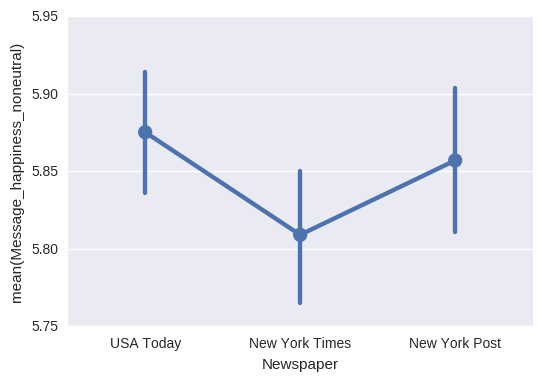

In [75]:
sns.pointplot(x="Newspaper",y="Message_happiness_noneutral",data=df_all)

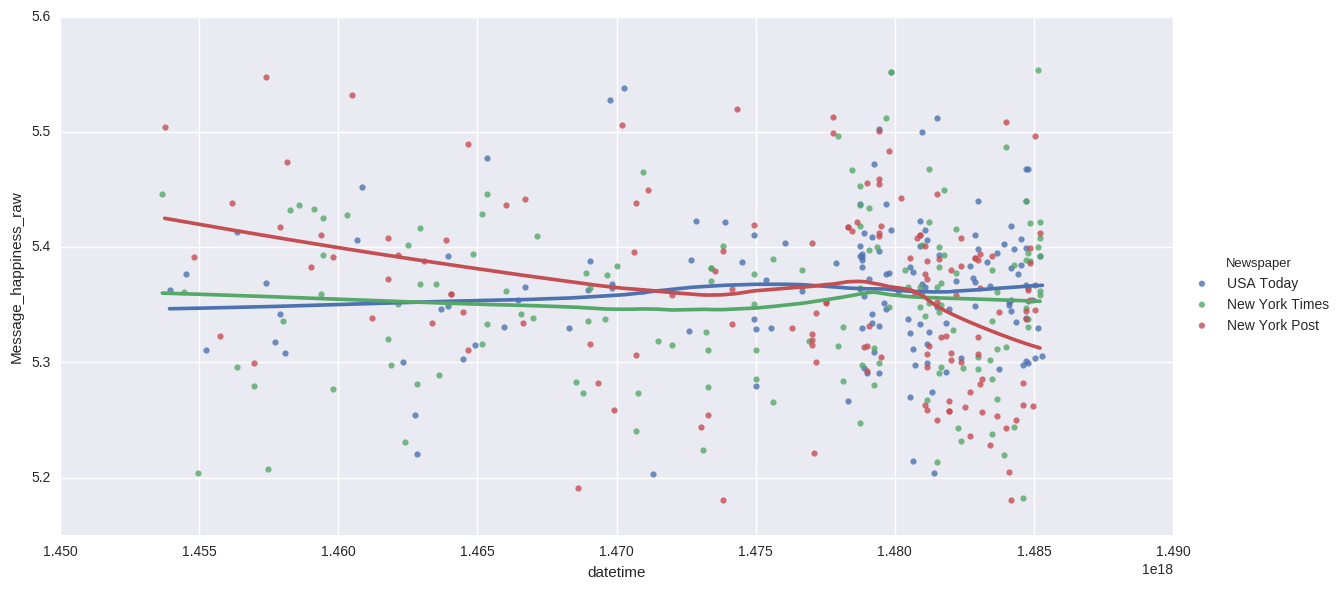

In [78]:
df_all["datetime"] = df_all["Date"].astype(int)
sns.lmplot(x="datetime",y="Message_happiness_noneutral",data=df_all,lowess=True,hue="Newspaper",aspect=2,size=6)
plt.ylim((5,6.5))

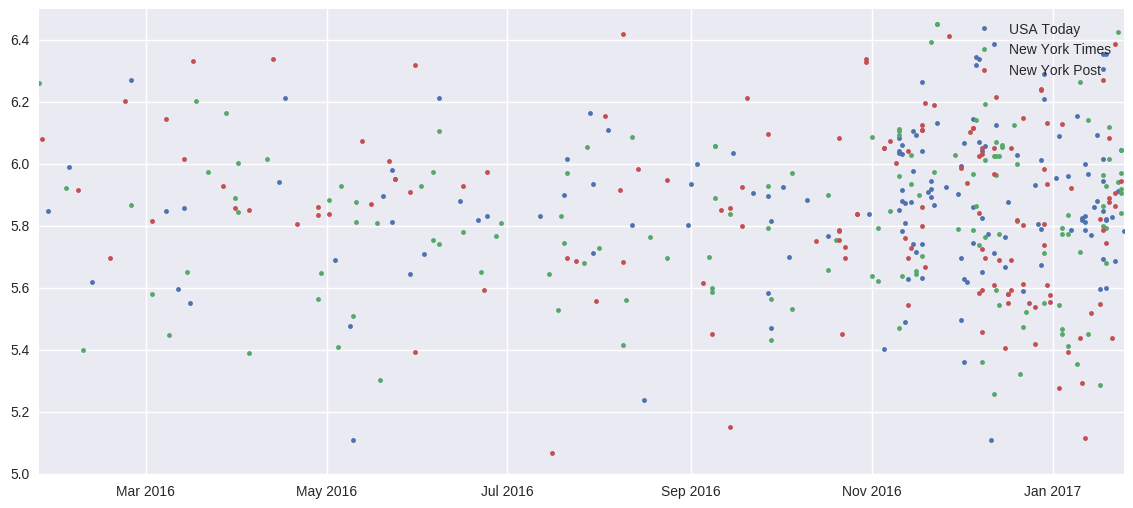

In [77]:
plt.figure(figsize=(14,6))
for newspaper,data in df_all.groupby("Newspaper",sort=False):
    #data = data.sort_values(by="Date")
    plt.plot(data["Date"],data["Message_happiness_noneutral"],".",label=newspaper)

plt.ylim((5,6.5))
plt.legend()


**We can resample to have a visualization per week**

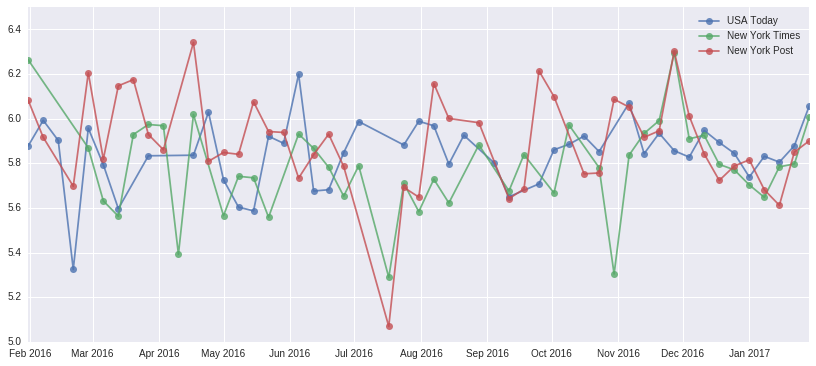

In [378]:
plt.figure(figsize=(14,6))
for newspaper,data in df_all.groupby("Newspaper",sort=False):
    data = data.sort_values(by="Date").resample("W",on="Date").mean().reset_index().dropna()
    plt.plot(data["Date"],data["Message_happiness_noneutral"],"o-",label=newspaper,alpha=0.8)
    
    plt.ylim((5,6.5))
plt.legend()


# 5. Classifying text
- 5.1 Based on some words
- 5.2 Based on some pre-coded
- 5.3 LDA

## 5.1 Based on some words
- We count the number of times some words appear

In [379]:
stemmer.stem("economy")

'economi'

In [86]:
election_topic = ["electi","presidenti","poll","vote","won","win"]
china_energy = ["coal","energy","gas"]
china_conflict = ["conflict","fight","war"]
china_jobs = ["trade","industry","job","economi"]

In [84]:
get_sum_count(["a","b","c","a"],["a","b"])

3

In [82]:
from collections import Counter
def get_sum_count(list_message,list_words):
    c = Counter(list_message)
    return sum([c[w] for w in list_words])

**How to count the number of words**

In [87]:
df_all["topic_election"] = df_all["Message_tokens_stemmed"].\
        apply(lambda x: get_sum_count(x,election_topic))
df_all["topic_energy"] = df_all["Message_tokens_stemmed"].apply(lambda x: get_sum_count(x,china_energy))
df_all["topic_conflict"] = df_all["Message_tokens_stemmed"].apply(lambda x: get_sum_count(x,china_conflict))
df_all["topic_jobs"] = df_all["Message_tokens_stemmed"].apply(lambda x: get_sum_count(x,china_jobs))
df_all.head(2)

,Date,Newspaper,Message,datetime,Message_tokens,Message_tokens_number_words,Message_tokens_stemmed,Message_tokens_no_stop,Message_happiness_raw,Message_happiness_noneutral,topic_election,topic_energy,topic_conflict,topic_jobs
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000,"[on, thursday, andrew, ross, sorkin, talked, t...",3117,"[on, thursday, andrew, ross, sorkin, talk, to,...","[thursday, andrew, ross, sorkin, talked, natio...",5.392737,6.041444,10,0,0,2
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000,"[syaru, shirley, lin, a, native, of, taiwan, i...",1221,"[syaru, shirley, lin, a, nativ, of, taiwan, is...","[syaru, shirley, lin, native, taiwan, politica...",5.393527,6.127549,0,0,0,8


**Calculate frequencies**

In [88]:
df_all["topic_election"] =  df_all["topic_election"]/df_all["Message_tokens_number_words"]
df_all["topic_energy"] =  df_all["topic_energy"]/df_all["Message_tokens_number_words"]
df_all["topic_conflict"] =  df_all["topic_conflict"]/df_all["Message_tokens_number_words"]
df_all["topic_jobs"] =  df_all["topic_jobs"]/df_all["Message_tokens_number_words"]
df_all.head(2)

,Date,Newspaper,Message,datetime,Message_tokens,Message_tokens_number_words,Message_tokens_stemmed,Message_tokens_no_stop,Message_happiness_raw,Message_happiness_noneutral,topic_election,topic_energy,topic_conflict,topic_jobs
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000,"[on, thursday, andrew, ross, sorkin, talked, t...",3117,"[on, thursday, andrew, ross, sorkin, talk, to,...","[thursday, andrew, ross, sorkin, talked, natio...",5.392737,6.041444,0.003208,0.0,0.0,0.000642
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000,"[syaru, shirley, lin, a, native, of, taiwan, i...",1221,"[syaru, shirley, lin, a, nativ, of, taiwan, is...","[syaru, shirley, lin, native, taiwan, politica...",5.393527,6.127549,0.000000,0.0,0.0,0.006552


**Visualize the topics**

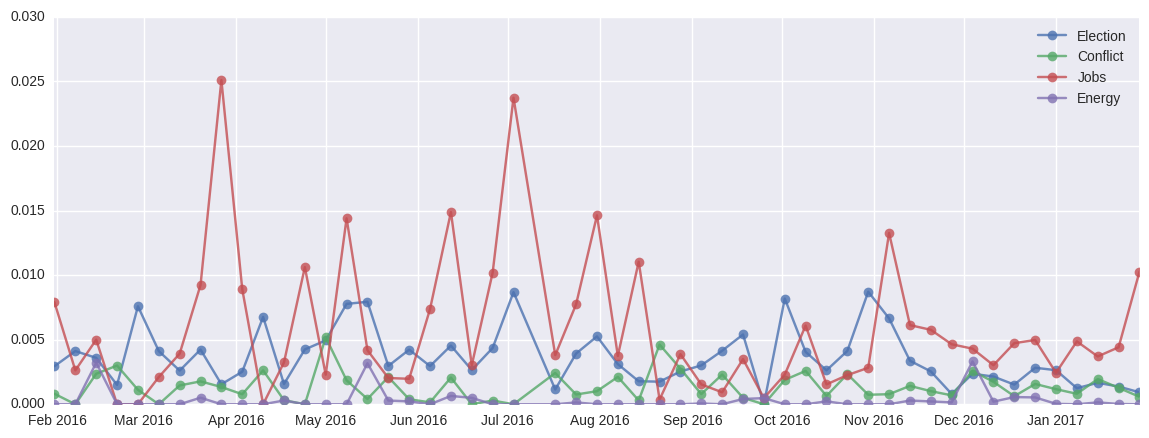

In [89]:
plt.figure(figsize=(14,5))
data = df_all.sort_values(by="Date").resample("W",on="Date").mean().reset_index().dropna()
plt.plot(data["Date"],data["topic_election"],"o-",label="Election",alpha=0.8)
plt.plot(data["Date"],data["topic_conflict"],"o-",label="Conflict",alpha=0.8)
plt.plot(data["Date"],data["topic_jobs"],"o-",label="Jobs",alpha=0.8)
plt.plot(data["Date"],data["topic_energy"],"o-",label="Energy",alpha=0.8)
plt.legend()

## 5.2 Based on some preclassified text (Supervised machine learning)
- You train a hundred articles by hand
- The computer does the rest and tell you the words that you used to classify those articles

In [91]:
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB



class ML_Classifier():

    def __init__(self,lang='english',alpha=.01):
        
        self.vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words=lang)
        self.clf = MultinomialNB(alpha=alpha)
        
    def train(self,messages,categories):
        # Adapted from below
        # Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
        #         Olivier Grisel <olivier.grisel@ensta.org>
        #         Mathieu Blondel <mathieu@mblondel.org>
        #         Lars Buitinck <L.J.Buitinck@uva.nl>
        # License: BSD 3 clause
        X_train = self.vectorizer.fit_transform(messages)
        self.clf.fit(X_train, categories)

        feature_names = np.array(self.vectorizer.get_feature_names())
        
        
        print("top 30 keywords per class:")
        for i, category in enumerate(set(categories)):
            top10 = np.argsort(self.clf.coef_[i])[-30:]
            print("{0}: {1}".format(category, " ".join(feature_names[top10])))
            print("-"*20)
        print()
        
        
    
    def test(self,messages,categories):
        X_test = self.vectorizer.transform(messages)
        pred = self.clf.predict(X_test)
        score = metrics.f1_score(categories, pred)
        print("f1-score:   %0.3f" % score)
    
    
    def predict(self,messages):
        X_test = self.vectorizer.transform(messages)
        pred = self.clf.predict(X_test)
        pred_prob = self.clf.predict_proba(X_test)


        return pred





In [92]:
#trade 1,conflict 2,elections 3,energy 4 none 9
df_train = pd.read_csv("data/train_data.csv",sep="\t",header=None)
df_train.head()

,0,1
0,hong kong -- an american labor union is pushin...,1
1,after delegates to the republican national con...,3
2,"for years, chief executive officers lived in f...",9
3,"given recent history, the next president can e...",9
4,1. we'll get to the major stories of the day i...,9


In [93]:
classifier = ML_Classifier("english",0.01)
classifier.train(df_train[0],df_train[1])


top 30 keywords per class:
1: including rising aluminum lot markets domestic asia billion impose asian free mexico companies manipulator policies global xi tariffs country america beijing japan countries jobs tax exports workers currency imports percent
--------------------
2: pacific saturday professor support university ing wen kuomintang ministry leaders phone region independence decades diplomatic relationship deal washington arms xi asia island ties military ms relations taiwanese tsai beijing taiwan
--------------------
3: voters elizabeth lobbyist nasty legislation prospects conservative miss gov pence mike roll kasich ryan madden isn let christie floor guilty women woman sloane chastain theme clinton movie film national convention
--------------------
4: keeps alliances defending keeping kyoto fast emissions thirty thecurrent terrorism basing ii counter 843 footprint unified puts carbon climate sea worth paris south gas annually allies global gets trillion maritime
------------

In [94]:

df_all['Category'] = classifier.predict(df_all['Message'])
df_all.head(2)

,Date,Newspaper,Message,datetime,Message_tokens,Message_tokens_number_words,Message_tokens_stemmed,Message_tokens_no_stop,Message_happiness_raw,Message_happiness_noneutral,topic_election,topic_energy,topic_conflict,topic_jobs,Category
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000,"[on, thursday, andrew, ross, sorkin, talked, t...",3117,"[on, thursday, andrew, ross, sorkin, talk, to,...","[thursday, andrew, ross, sorkin, talked, natio...",5.392737,6.041444,0.003208,0.0,0.0,0.000642,9
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000,"[syaru, shirley, lin, a, native, of, taiwan, i...",1221,"[syaru, shirley, lin, a, nativ, of, taiwan, is...","[syaru, shirley, lin, native, taiwan, politica...",5.393527,6.127549,0.000000,0.0,0.0,0.006552,2


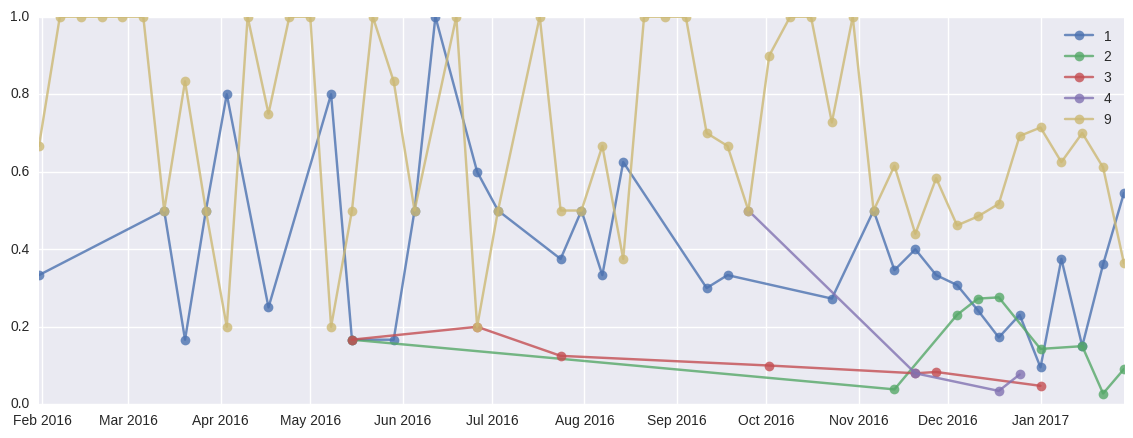

In [95]:
plt.figure(figsize=(14,5))
df_all["count"] = 1
data_week = df_all.sort_values(by="Date").resample("W",on="Date").sum().reset_index().dropna().loc[:,["Date","count"]]
data_week.columns = ["Date","c"]

for category,data_c in df_all.groupby("Category"):
    data = data_c.sort_values(by="Date").resample("W",on="Date").sum().reset_index().dropna()
    data = pd.merge(data,data_week,on=["Date"])
    plt.plot(data["Date"],data["count"]/data["c"],"o-",label=category,alpha=0.8)
plt.legend()

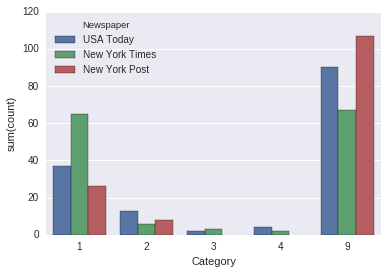

In [321]:
sns.barplot(hue="Newspaper",x="Category",y="count",estimator=np.sum,data=df_all)

## 5.2b Understand differences between groups
- Give the computer different articles (by newspaper)
- The computer tells which distinct words they use

In [391]:
classifier = ML_Classifier("english",0.01)
classifier.train(df_all["Message"],df_all["Newspaper"])


top 30 keywords per class:
USA Today: ll media campaign foreign million percent national israel security state think country chinese house going washington trade elect election policy don just america post russia taiwan told hillary obama clinton
New York Times: rate campaign according growth business workers country nuclear election elect foreign countries obama 000 mexico companies manufacturing republican tax america state economy presidential policy usa economic says clinton jobs trade
New York Post: political economic countries did officials ms going mrs twitter south election white news clinton foreign state washington beijing government york times chinese policy campaign administration country trade obama percent mr



## 5.3 Automatic document clustering (Unsupervised machine learning)
- Usually based on LDA (Latent Dirichet Allocation)
- You give a number of topic to find (very tricky topic), the computer does the rest

In [96]:
import lda
import pickle
from nltk.corpus import stopwords

import bisect

class LDA():
    def __init__(self,lang="english"):
        self.lang = lang
        self.vocab = self.create_dictionary()
        
        
    def create_dictionary(self):
        """
        top 5000 words, using labMTsimple
        """
        from labMTsimple.storyLab import emotionFileReader, emotion, stopper, emotionV
        labMT,labMTvector,labMTwordList = emotionFileReader(stopval=0.0,lang=self.lang,returnVector=True)
        return  sorted(list(set(labMTwordList) - set(stopwords.words("english")) ))
        
        

    def bi_contains(self,lst, item):
        """ efficient `item in lst` for sorted lists """
        pos = bisect.bisect_left(lst, item)
        return [((item <= lst[-1]) and (lst[pos] == item)),pos]


    def train(self,messages,topicNum,n_iter=1000):
        len_vocab = len(self.vocab)
        print("Number of articles: {0}".format(len(messages)))
        allMessages = np.zeros((len(messages),len_vocab))
        j = -1
        for mess in messages:
            j += 1
            # Kind-of efficient way to count words (better to use a dictionary)
            c = Counter(mess)
            del c['']
            values = np.zeros(len_vocab)
            for word in c:
                pos = self.bi_contains(self.vocab, word)
                if pos[0]:
                    values[pos[1]] = c[word]
            allMessages[j,:] += values

        allMessages = np.array(allMessages,dtype=int)
        self.corpus = allMessages
    
        print("Corpus created, running lda")
        
        #run lda with allMessages and print topics
        model = lda.LDA(n_topics=topicNum, n_iter=n_iter, random_state=1)

        model.fit(self.corpus )
        topic_word = model.topic_word_
        #print(model.loglikelihood())
        
        for i, topic_dist in enumerate(topic_word):
            topic_words = np.array(self.vocab)[np.argsort(topic_dist)][:]#-[:n_top_words:-1]
            freq_words = np.array(topic_dist)[np.argsort(topic_dist)][:]#-n_top_words:-1]

            print('Topic {}: {}'.format(i, ' '.join(topic_words[::-1][:30])))
            #print('Topic {}: {}'.format(i, ' '.join([str(_) for _ in freq_words[::-1][:10]])))


        doc_topic = model.doc_topic_

        return model.doc_topic_.argmax(1)

    



In [97]:
latent = LDA()
categories = latent.train(df_all["Message_tokens"],topicNum=5,n_iter=1000)


Number of articles: 429


INFO:lda:n_documents: 429
INFO:lda:vocab_size: 10081
INFO:lda:n_words: 187183
INFO:lda:n_topics: 5
INFO:lda:n_iter: 1000


Corpus created, running lda


INFO:lda:<0> log likelihood: -1830845
INFO:lda:<10> log likelihood: -1596608
INFO:lda:<20> log likelihood: -1540165
INFO:lda:<30> log likelihood: -1524901
INFO:lda:<40> log likelihood: -1516316
INFO:lda:<50> log likelihood: -1510512
INFO:lda:<60> log likelihood: -1508850
INFO:lda:<70> log likelihood: -1505968
INFO:lda:<80> log likelihood: -1504470
INFO:lda:<90> log likelihood: -1504243
INFO:lda:<100> log likelihood: -1502661
INFO:lda:<110> log likelihood: -1503106
INFO:lda:<120> log likelihood: -1501469
INFO:lda:<130> log likelihood: -1502477
INFO:lda:<140> log likelihood: -1501309
INFO:lda:<150> log likelihood: -1500138
INFO:lda:<160> log likelihood: -1500473
INFO:lda:<170> log likelihood: -1500190
INFO:lda:<180> log likelihood: -1500481
INFO:lda:<190> log likelihood: -1500135
INFO:lda:<200> log likelihood: -1499768
INFO:lda:<210> log likelihood: -1499671
INFO:lda:<220> log likelihood: -1499440
INFO:lda:<230> log likelihood: -1499699
INFO:lda:<240> log likelihood: -1500361
INFO:lda:<2

Topic 0: people going think would get clinton president country know one well like want us make good say way years right much go great america new lot back see really look
Topic 1: trade trump would u china jobs says companies economy economic year could percent company market said tax global growth mexico financial american billion also business markets world investors government workers
Topic 2: mr trump said united states president obama american russia would world policy foreign nuclear china security u north could war japan america korea administration military countries intelligence iran also leaders
Topic 3: china said president taiwan one chinese new call beijing government us million donald city meeting news department post group told officials including team may washington york former called also high
Topic 4: trump said clinton republican presidential election campaign party political like state house white hillary donald year time new told one democratic two would first nat

In [98]:
df_all["Categories_LDA"] = categories
df_all.head(2)

,Date,Newspaper,Message,datetime,Message_tokens,Message_tokens_number_words,Message_tokens_stemmed,Message_tokens_no_stop,Message_happiness_raw,Message_happiness_noneutral,topic_election,topic_energy,topic_conflict,topic_jobs,Category,count,Categories_LDA
681,2016-11-10,USA Today,"on thursday, andrew ross sorkin talked to the ...",1478736000000000000,"[on, thursday, andrew, ross, sorkin, talked, t...",3117,"[on, thursday, andrew, ross, sorkin, talk, to,...","[thursday, andrew, ross, sorkin, talked, natio...",5.392737,6.041444,0.003208,0.0,0.0,0.000642,9,1,4
805,2016-12-13,USA Today,"syaru shirley lin, a native of taiwan, is a po...",1481587200000000000,"[syaru, shirley, lin, a, native, of, taiwan, i...",1221,"[syaru, shirley, lin, a, nativ, of, taiwan, is...","[syaru, shirley, lin, native, taiwan, politica...",5.393527,6.127549,0.000000,0.0,0.0,0.006552,2,1,3


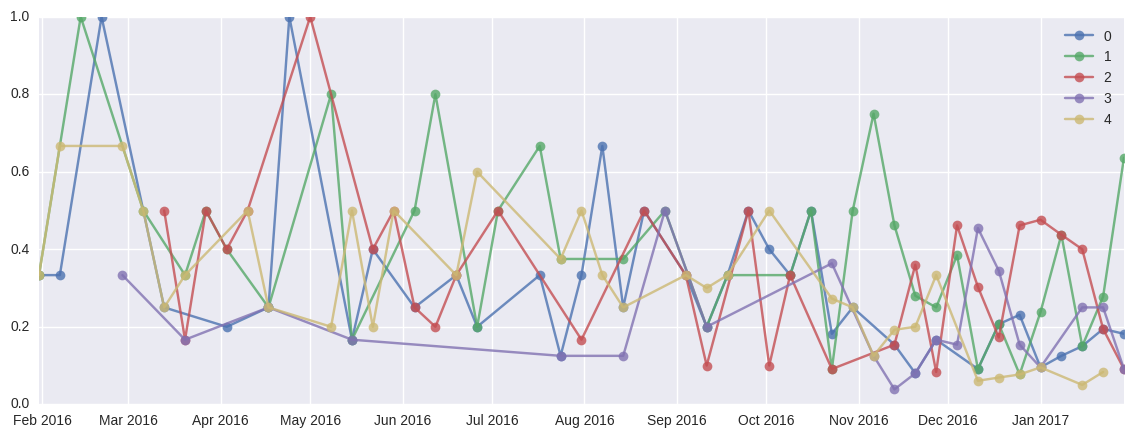

In [99]:
plt.figure(figsize=(14,5))
df_all["count"] = 1
data_week = df_all.sort_values(by="Date").resample("W",on="Date").sum().reset_index().dropna().loc[:,["Date","count"]]
data_week.columns = ["Date","c"]

for category,data_c in df_all.groupby("Categories_LDA"):
    data = data_c.sort_values(by="Date").resample("W",on="Date").sum().reset_index().dropna()
    data = pd.merge(data,data_week,on=["Date"])
    plt.plot(data["Date"],data["count"]/data["c"],"o-",label=category,alpha=0.8)
plt.legend()

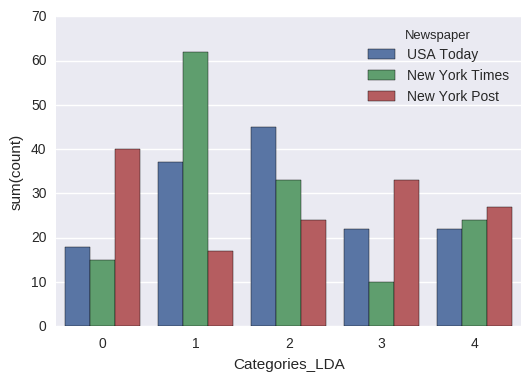

In [100]:
"""
Topic 0: people going think would get clinton president country know one well like want us make good say way years right much go great america new lot back see really look
Topic 1: trade trump would u china jobs says companies economy economic year could percent company market said tax global growth mexico financial american billion also business markets world investors government workers
Topic 2: mr trump said united states president obama american russia would world policy foreign nuclear china security u north could war japan america korea administration military countries intelligence iran also leaders
Topic 3: china said president taiwan one chinese new call beijing government us million donald city meeting news department post group told officials including team may washington york former called also high
Topic 4: trump said clinton republican presidential election campaign party political like state house white hillary donald year time new told one democratic two would first national candidate media voters speech left"""
sns.barplot(hue="Newspaper",x="Categories_LDA",y="count",estimator=np.sum,data=df_all)